In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label,regionprops
import os
from numba import jit
from sklearn.cluster import KMeans

In [2]:
colors = {'artery':np.array([255,0,0]),
          'liver':np.array([255,0,255]),
          'stomach':np.array([0,255,0]),
          'vein':np.array([0,0,255])}
folder = 'ARRAY_FORMAT'
data_files = [os.path.join(folder,name) for name in os.listdir(folder)]
ORGAOS = ['artery', 'liver', 'stomach', 'vein']
len(data_files)

1588

In [3]:
def load(name):
    data = np.load(name,allow_pickle=True).flatten()[0]
    img = data['image']
    structures = data['structures']
    if len(img.shape) == 3:
        img = img[:,:,0]
    return img,structures

def detect_main_area(img):
    mask = (img > 0).astype('uint8')
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25))
    mask = cv2.erode(mask,kernel,iterations = 1)
    mask = cv2.dilate(mask,kernel,iterations = 1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(95,95))
    mask = cv2.dilate(mask,kernel,iterations = 1)
    mask = cv2.erode(mask,kernel,iterations = 1)
    objetos = label(mask)
    info = regionprops(objetos)
    main_label = max(info,key = lambda x: x['area'])['label']
    return objetos == main_label

def clean(img):
    return (img * (detect_main_area(img))).astype('uint8')

def create_reshape(img_clean):
    img = img_clean
    arx = np.arange(img.shape[1])
    ary = np.arange(img.shape[0])
    min_y = min(ary,key = lambda x: np.inf if (img[x] == 0).all() else x)
    max_y = max(ary,key = lambda x: 0 if (img[x] == 0).all() else x)
    min_x = min(arx,key = lambda x: np.inf if (img[:,x] == 0).all() else x)
    max_x = max(arx,key = lambda x: 0 if (img[:,x] == 0).all() else x)
    min_x_top = min(arx,key = lambda x: np.inf if img[min_y + 10,x] == 0 else x)
    max_x_top = max(arx,key = lambda x: 0 if img[min_y + 10,x] == 0 else x)
    dis_left = min_x_top - min_x
    dis_right = max_x - max_x_top
    if dis_left > dis_right:
        max_x = min(max_x_top + dis_left,img.shape[1] - 1)
    if dis_left < dis_right:
        min_x = max(min_x_top - dis_right,0)
    max_x = max_x - min_x
    max_y = max_y - min_y
    return (min_y,max_y,min_x,max_x)

@jit(nopython = True)
def transform(imagem,scaler):
    newshape = 192,256
    newimagem = np.zeros(newshape,'uint8')
    for y in range(newshape[0]):
        for x in range(newshape[1]):
            ny,nx = int((y / newshape[0]) * scaler[1] + scaler[0]),int((x / newshape[1]) * scaler[3] + scaler[2])
            newimagem[y,x] = imagem[ny,nx]
    return newimagem

def transform_struc(structures,scaler):
    resh = {}
    for key in structures:
        resh[key] = transform(structures[key],scaler)
    return resh

def reduce(img):
    n = 30
    return img[n:-n,n:-n].copy()

def reduce_struc(structures):
    red = {}
    for key in structures:
        red[key] = reduce(structures[key])
    return red

_ = transform(np.zeros((10,10)),(0,0,0,0))

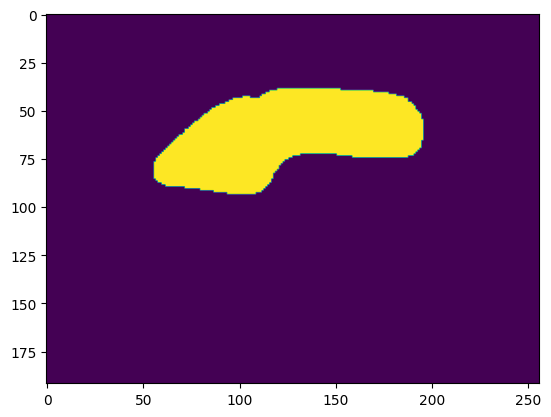

In [97]:
# test_img , test_str = load()

# # Plotar a imagem de fundo
# plt.figure()
# plt.imshow(test_img, cmap='gray')  # ou cmap='viridis', etc. dependendo da sua imagem
# mask = test_str['liver']
# colored_mask = np.zeros((*mask.shape, 4), dtype=np.uint8)  # Adicionar canal alpha
# colored_mask[mask == 1] = [255, 0, 0, 255]  # Vermelho com transparência 50%
# # Sobrepor a máscara
# plt.imshow(colored_mask, cmap='Reds', alpha=0.2)  # cmap='Reds' define a cor para a máscara, alpha define a transparência
# # Mostrar a imagem
# plt.show()
img,structures = load(data_files[0])
cleaned = clean(img)
scaler = create_reshape(cleaned)
tstruc = transform_struc(structures,scaler)
plt.imshow(tstruc["liver"])
rstruc = reduce_struc(tstruc)
size = rstruc[list(rstruc.keys())[0]].shape
arr = np.zeros((size[0] + size[1]) * 4,'uint8')


i = 0
for key in ORGAOS:
    if key not in rstruc:
        i += size[0] + size[1]
        continue
    labels = rstruc[key]
    arr[i:i + size[1]] = labels.any(axis = 0)
    i += size[1]
    arr[i:i + size[0]] = labels.any(axis = 1)
    i += size[0]




In [4]:
linear = {}
for j,file in enumerate(data_files):
    img,structures = load(file)
    cleaned = clean(img)
    scaler = create_reshape(cleaned)
    tstruc = transform_struc(structures,scaler)
    rstruc = reduce_struc(tstruc)
    size = rstruc[list(rstruc.keys())[0]].shape
    arr = np.zeros((size[0] + size[1]) * 4,'uint8')
    i = 0
    for key in ORGAOS:
        if key not in rstruc:
            i += size[0] + size[1]
            continue
        labels = rstruc[key]
        arr[i:i + size[1]] = labels.any(axis = 0)
        i += size[1]
        arr[i:i + size[0]] = labels.any(axis = 1)
        i += size[0]
    linear[file] = arr
    print('Files:',j,end = '\r')

In [5]:
linear_data = pd.DataFrame(linear.values(),index = linear.keys())
nclusters = 10
kmeans = KMeans(n_clusters = nclusters, random_state = 0,n_init = "auto").fit(linear_data.values)
clusters = pd.Series(kmeans.labels_,linear.keys())


In [6]:
classes = {}
templates = {}
i = 0
for cl in clusters.unique():
    mod = np.zeros((132, 196),'uint64')
    templates[cl] = {org:np.zeros((132, 196),'uint64') for org in ORGAOS}
    for name in clusters[clusters == cl].index:
        img,structures = load(name)
        cleaned = clean(img)
        scaler = create_reshape(cleaned)
        tstruc = transform_struc(structures,scaler)
        rstruc = reduce_struc(tstruc)
        for key in ['artery', 'stomach', 'vein']:
            if key not in rstruc:
                continue
            mod += rstruc[key]
            templates[cl][key] += rstruc[key]
        if 'liver' in rstruc:
            templates[cl]['liver'] += rstruc['liver']
        print('Files:',i,end = '\r')
        i += 1
    size = len(clusters[clusters == cl])
    classes[cl] = mod / size
    for key in ORGAOS:
        templates[cl][key] = templates[cl][key] / size

In [7]:
for cl in clusters.unique():
    cv2.imwrite(os.path.join('MODEL/classes',f'{cl}.png'),classes[cl] * 255)
    for key in templates[cl]:
        cv2.imwrite(os.path.join('MODEL/templates',key,f'{cl}.png'),templates[cl][key] * 255)